In [73]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# download cifar10 dataset
from torchvision.datasets import CIFAR10

ds = CIFAR10(root='./datasets',download=True)
torch.set_default_device('cuda')

Files already downloaded and verified


In [74]:
data = torch.tensor(ds.data).float() / 255.
noise = torch.rand(*data.shape[:-1],1)
add_noise = True
if add_noise: data = torch.cat([data, noise], dim=-1)
train_data, test_data = data.split([40000, 10000])
targets = torch.tensor(ds.targets)
train_targets, test_targets = targets.split([40000, 10000])

In [75]:
class CNN(nn.Module):
  def __init__(self, channels=3):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(channels, 64, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(256 * 4 * 4, 512)
    self.fc2 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    x = x.permute(0,3,1,2)
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.fc2(x)
    return x

net = CNN(4)
assert net(train_data[:5]).shape == torch.Size([5,10])
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [77]:
epochs = 10
batch_size = 32


results = []

for noisy in range(2):

  runs = []
  for r in range(4):
    net = CNN(channels=3 if noisy == 0 else 4)
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    test_loss = []
    for epoch in range(epochs):
      net.train(True)
      for i in range(0,len(train_data),batch_size):
        x = train_data[i:i+batch_size,:,:,:3 if noisy == 0 else 4]
        y = train_targets[i:i+batch_size]
        opt.zero_grad()
        out = net(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()
      net.train(False)
      with torch.no_grad():
        out = net(test_data[:,:,:,:3 if noisy == 0 else 4])
        pred = out.argmax(1)
        acc = (pred == test_targets).float().mean()
        loss = F.cross_entropy(out, test_targets)
      test_loss.append((loss.item(),acc.item()))
    runs.append((test_loss))
  results.append(runs)

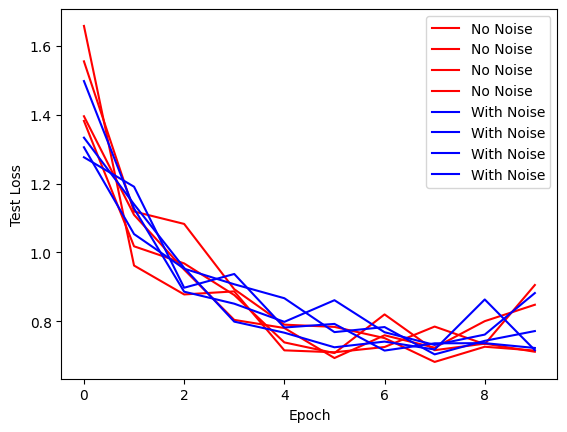

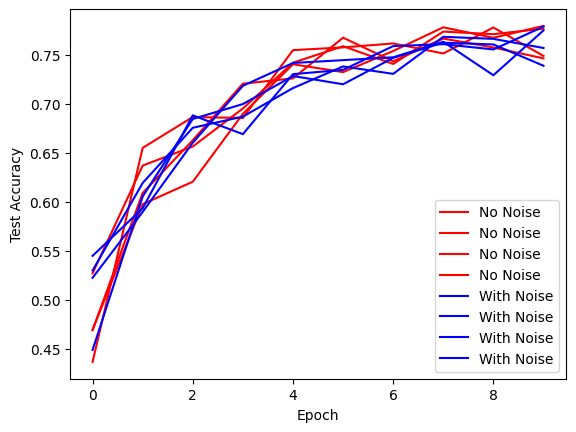

In [78]:
for i, result in enumerate(results):
  for run in result: plt.plot([r[0] for r in run], c='r' if i == 0 else 'b')

plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend(['No Noise']*4+['With Noise']*4)
plt.show()

for i, result in enumerate(results):
  for run in result: plt.plot([r[1] for r in run], c='r' if i == 0 else 'b')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend(['No Noise']*4+['With Noise']*4)
plt.show()